# Fun with JAX

**Prepared for the Bank of Portugal Computational Economics Course (Oct 2025)**

**Author:** [John Stachurski](https://johnstachurski.net)

October 2025

This is a super quick illustration of the power of [JAX](https://github.com/google/jax), a Python library built by Google Research.

It should be run on a machine with a GPU --- for example, try Google Colab with the runtime environment set to include a GPU.

The aim is just to give a small taste of high performance computing in Python -- details will be covered later in the course.

We start with some imports

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

Let's check our hardware:

In [2]:
!nvidia-smi

Thu Oct  9 07:27:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!lscpu -e

CPU NODE SOCKET CORE L1d:L1i:L2:L3 ONLINE
  0    0      0    0 0:0:0:0          yes
  1    0      0    0 0:0:0:0          yes


## Transforming Data

A very common numerical task is to apply a transformation to a set of data points.

Our transformation will be the cosine function.

Here we evaluate the cosine function at 50 points.

In [4]:
x = np.linspace(0, 10, 50)
y = np.cos(x)

Let's plot.

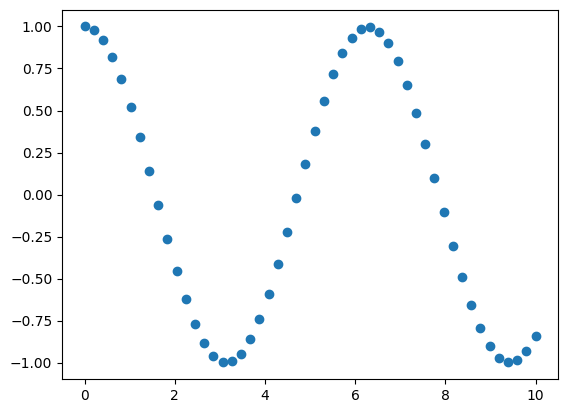

In [5]:
fig, ax = plt.subplots()
ax.scatter(x, y)
plt.show()

Our aim is to evaluate the cosine function at many points.

In [6]:
n = 50_000_000
x = np.linspace(0, 10, n)

### With NumPy

In [7]:
%%time

y = np.cos(x)

CPU times: user 660 ms, sys: 80.1 ms, total: 740 ms
Wall time: 740 ms


In [8]:
%%time

y = np.cos(x)

CPU times: user 713 ms, sys: 82.2 ms, total: 795 ms
Wall time: 807 ms


In [9]:
x = None

### With JAX

In [10]:
x_jax = jnp.linspace(0, 10, n)

Let's time it.


In [11]:
%%time

y = jnp.cos(x_jax)
jax.block_until_ready(y);  # Don't run forward until the array is returned

CPU times: user 51.9 ms, sys: 3.78 ms, total: 55.7 ms
Wall time: 93.5 ms


Array([ 1.        ,  1.        ,  1.        , ..., -0.83907205,
       -0.8390716 , -0.8390716 ], dtype=float32)

In [12]:
%%time

y = jnp.cos(x_jax)
jax.block_until_ready(y);

CPU times: user 1.49 ms, sys: 0 ns, total: 1.49 ms
Wall time: 1.97 ms


Array([ 1.        ,  1.        ,  1.        , ..., -0.83907205,
       -0.8390716 , -0.8390716 ], dtype=float32)

Here we change the input size --- can you explain why the timing changes?

In [13]:
x_jax = jnp.linspace(0, 10, n + 1)

In [14]:
%%time

y = jnp.cos(x_jax)
jax.block_until_ready(y);

CPU times: user 35.3 ms, sys: 96 µs, total: 35.4 ms
Wall time: 53.4 ms


Array([ 1.       ,  1.       ,  1.       , ..., -0.8390716, -0.8390716,
       -0.8390716], dtype=float32)

In [15]:
%%time

y = jnp.cos(x_jax)
jax.block_until_ready(y);

CPU times: user 1.14 ms, sys: 123 µs, total: 1.27 ms
Wall time: 2.36 ms


Array([ 1.       ,  1.       ,  1.       , ..., -0.8390716, -0.8390716,
       -0.8390716], dtype=float32)

In [16]:
x_jax = None  # Free memory

## Evaluating a more complicated function

In [17]:
def f(x):
    y = np.cos(2 * x**2) + np.sqrt(np.abs(x)) + 2 * np.sin(x**4) - 0.1 * x**2
    return y

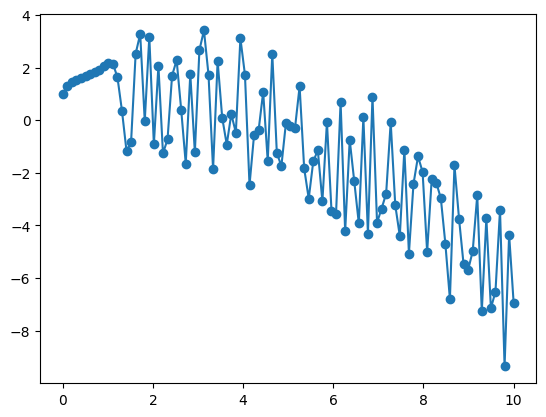

In [18]:
fig, ax = plt.subplots()
x = np.linspace(0, 10, 100)
ax.plot(x, f(x))
ax.scatter(x, f(x))
plt.show()

Now let's try with a large array.

### With NumPy

In [19]:
n = 50_000_000
x = np.linspace(0, 10, n)

In [20]:
%%time

y = f(x)

CPU times: user 3.44 s, sys: 514 ms, total: 3.96 s
Wall time: 4.01 s


In [21]:
%%time

y = f(x)

CPU times: user 2.95 s, sys: 468 ms, total: 3.42 s
Wall time: 3.42 s


### With JAX

In [22]:
def f(x):
    y = jnp.cos(2 * x**2) + jnp.sqrt(jnp.abs(x)) + 2 * jnp.sin(x**4) - x**2
    return y

In [23]:
x_jax = jnp.linspace(0, 10, n)

In [24]:
%%time

y = f(x_jax)
jax.block_until_ready(y);

CPU times: user 234 ms, sys: 6.39 ms, total: 240 ms
Wall time: 350 ms


Array([  1.       ,   1.0004472,   1.0006324, ..., -96.95619  ,
       -96.96176  , -96.96176  ], dtype=float32)

In [25]:
%%time

y = f(x_jax)
jax.block_until_ready(y)

CPU times: user 5.21 ms, sys: 41 µs, total: 5.25 ms
Wall time: 22.5 ms


Array([  1.       ,   1.0004472,   1.0006324, ..., -96.95619  ,
       -96.96176  , -96.96176  ], dtype=float32)

### Compiling the Whole Function

In [26]:
f_jax = jax.jit(f)

In [27]:
%%time

y = f_jax(x_jax)
jax.block_until_ready(y);

CPU times: user 85.8 ms, sys: 1.76 ms, total: 87.6 ms
Wall time: 135 ms


Array([  1.       ,   1.0004472,   1.0006324, ..., -96.95619  ,
       -96.96176  , -96.96176  ], dtype=float32)

In [28]:
%%time

y = f_jax(x_jax)
jax.block_until_ready(y);

CPU times: user 1.41 ms, sys: 0 ns, total: 1.41 ms
Wall time: 2.41 ms


Array([  1.       ,   1.0004472,   1.0006324, ..., -96.95619  ,
       -96.96176  , -96.96176  ], dtype=float32)